In [1]:
# Let's start off by importing the relevant libraries
import pandas as pd
import numpy as np
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data_df = pd.read_csv("../input/UKPN-LCL-smartmeter-sample.csv", header=0) # creates a Pandas data frame for input value


In [3]:

raw_data_df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC003718,Std,17/10/2012 13:00:00,0.09,ACORN-A,Affluent
1,MAC003718,Std,17/10/2012 13:30:00,0.16,ACORN-A,Affluent
2,MAC003718,Std,17/10/2012 14:00:00,0.212,ACORN-A,Affluent
3,MAC003718,Std,17/10/2012 14:30:00,0.145,ACORN-A,Affluent
4,MAC003718,Std,17/10/2012 15:00:00,0.104,ACORN-A,Affluent


In [4]:
len(raw_data_df)

17458

In [5]:
result=raw_data_df
result['date']=pd.to_datetime(result['DateTime'])
data=result.loc[:, ['KWH/hh (per half hour) ']]
data = data.set_index(result.date)
data['KWH/hh (per half hour) '] = pd.to_numeric(data['KWH/hh (per half hour) '],downcast='float',errors='coerce')

In [6]:
data.head()


,KWH/hh (per half hour)
date,
2012-10-17 13:00:00,0.090
2012-10-17 13:30:00,0.160
2012-10-17 14:00:00,0.212
2012-10-17 14:30:00,0.145
2012-10-17 15:00:00,0.104


In [7]:
daily = data.resample('D').sum()


In [8]:
daily.head()

,KWH/hh (per half hour)
date,
2012-01-11,11.501
2012-01-12,11.687
2012-01-13,0.000
2012-01-14,0.000
2012-01-15,0.000


**LSTM Prediction**

In [9]:
mydata=daily.loc[:, ['KWH/hh (per half hour) ']]
mydata = mydata.set_index(daily.index)
mydata.head()

,KWH/hh (per half hour)
date,
2012-01-11,11.501
2012-01-12,11.687
2012-01-13,0.000
2012-01-14,0.000
2012-01-15,0.000


In [10]:
from sklearn.preprocessing import MinMaxScaler
values = mydata['KWH/hh (per half hour) '].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

560 140


In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

558
138


In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY) , verbose=0, shuffle=False)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


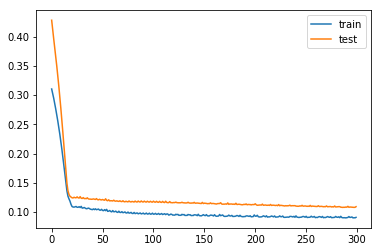

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

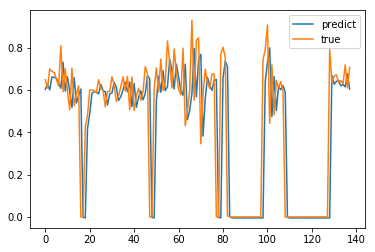

In [17]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()

In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.126


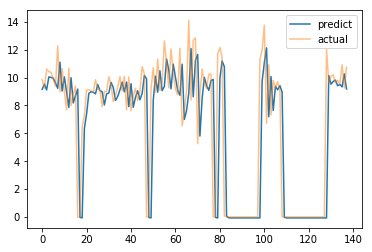

In [19]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()

**PROPHET Prediction**

In [20]:
df2=daily
df2.reset_index(inplace=True)
# Prophet requires columns ds (Date) and y (value)
df2 = df2.rename(columns={'date': 'ds', 'KWH/hh (per half hour) ': 'y'})

df2.head()

,ds,y
0,2012-01-11,11.501
1,2012-01-12,11.687
2,2012-01-13,0.000
3,2012-01-14,0.000
4,2012-01-15,0.000


In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import fbprophet
# Make the prophet model and fit on the data
df2_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10)
df2_prophet.fit(df2)
warnings.resetwarnings()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# Make a future dataframe for 2 month
df2_forecast = df2_prophet.make_future_dataframe(periods=30*2, freq='D')
# Make predictions
df2_forecast = df2_prophet.predict(df2_forecast)

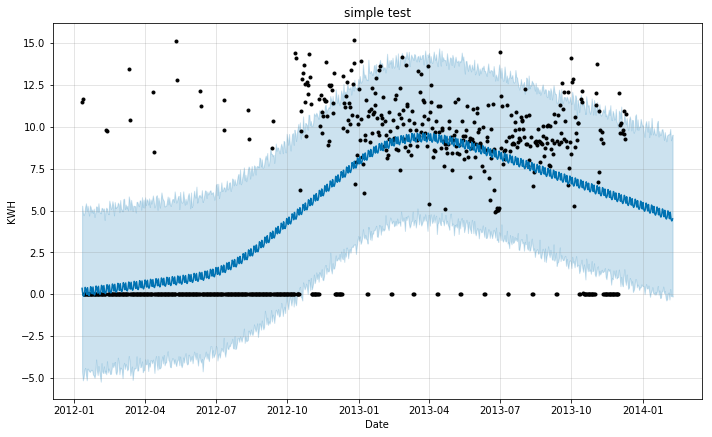

In [23]:
df2_prophet.plot(df2_forecast, xlabel = 'Date', ylabel = 'KWH')
plt.title('simple test');

In [24]:
df2_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-11,0.109048,-4.637899,5.289920,0.109048,0.109048,0.238901,0.238901,0.238901,0.238901,0.238901,0.238901,0.0,0.0,0.0,0.347949
1,2012-01-12,0.114781,-5.150005,4.865540,0.114781,0.114781,-0.155118,-0.155118,-0.155118,-0.155118,-0.155118,-0.155118,0.0,0.0,0.0,-0.040337
2,2012-01-13,0.120514,-4.950054,4.720813,0.120514,0.120514,-0.244993,-0.244993,-0.244993,-0.244993,-0.244993,-0.244993,0.0,0.0,0.0,-0.124479
3,2012-01-14,0.126248,-4.511154,4.863614,0.126248,0.126248,-0.108051,-0.108051,-0.108051,-0.108051,-0.108051,-0.108051,0.0,0.0,0.0,0.018196
4,2012-01-15,0.131981,-4.416012,5.239271,0.131981,0.131981,0.272907,0.272907,0.272907,0.272907,0.272907,0.272907,0.0,0.0,0.0,0.404888
5,2012-01-16,0.137714,-4.822232,5.432982,0.137714,0.137714,0.154247,0.154247,0.154247,0.154247,0.154247,0.154247,0.0,0.0,0.0,0.291961
6,2012-01-17,0.143447,-5.145131,4.987250,0.143447,0.143447,-0.157892,-0.157892,-0.157892,-0.157892,-0.157892,-0.157892,0.0,0.0,0.0,-0.014445
7,2012-01-18,0.149180,-4.443774,5.283679,0.149180,0.149180,0.238901,0.238901,0.238901,0.238901,0.238901,0.238901,0.0,0.0,0.0,0.388081
8,2012-01-19,0.154913,-4.505257,5.008617,0.154913,0.154913,-0.155118,-0.155118,-0.155118,-0.155118,-0.155118,-0.155118,0.0,0.0,0.0,-0.000205
9,2012-01-20,0.160646,-4.599188,4.699224,0.160646,0.160646,-0.244993,-0.244993,-0.244993,-0.244993,-0.244993,-0.244993,0.0,0.0,0.0,-0.084347
